# SVM & MLPNN

16307110216 Ruian He

### Extract data from downloaded files

As the data is stored in bytes, we need to follow the strcture of the files to extract.

In [2]:
import numpy as np
import gzip,struct,os


'''
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000803(2051) magic number
0004     32 bit integer  60000            number of images
0008     32 bit integer  28               number of rows
0012     32 bit integer  28               number of columns
0016     unsigned byte   ??               pixel
'''

def extract_image(file_path):
    print("Extracting:",file_path)
    with gzip.GzipFile(fileobj=open(file_path,mode='rb')) as buf:
        magic,num,row,col = struct.unpack('>4I',buf.read(4*4))
        if magic != 2051:
            raise ValueError('Invalid magic number %d in MNIST image file: %s' %(magic, file_path))
        image = np.frombuffer(buf.read(num*row*col), dtype=np.uint8)
        return image.reshape(num,row,col).astype(int)
    
'''
[offset] [type]          [value]          [description]
0000     32 bit integer  0x00000801(2049) magic number (MSB first)
0004     32 bit integer  60000            number of items
0008     unsigned byte   ??               label
'''
    
def extract_label(file_path):
    print("Extracting:",file_path)
    with gzip.GzipFile(fileobj=open(file_path,mode='rb')) as buf:
        magic,num = struct.unpack('>2I',buf.read(2*4))
        if magic != 2049:
            raise ValueError('Invalid magic number %d in MNIST label file: %s' %(magic, file_path))
        label = np.frombuffer(buf.read(num), dtype=np.uint8)
        return label.astype(int)

Then we do the above approaches on our MNIST dataset.

In [3]:
data_dir = '../mnist'

train_image_file = "train-images-idx3-ubyte.gz"
train_label_file = "train-labels-idx1-ubyte.gz"
test_image_file = "t10k-images-idx3-ubyte.gz"
test_label_file = "t10k-labels-idx1-ubyte.gz"

X_train = extract_image(os.path.join(data_dir,train_image_file))
print('Training data shape: ', X_train.shape)
y_train = extract_label(os.path.join(data_dir,train_label_file))
print('Training labels shape: ', y_train.shape)
X_test = extract_image(os.path.join(data_dir,test_image_file))
print('Test data shape: ', X_test.shape)
y_test = extract_label(os.path.join(data_dir,test_label_file))
print('Test labels shape: ', y_test.shape)

Extracting: ../mnist/train-images-idx3-ubyte.gz
Training data shape:  (60000, 28, 28)
Extracting: ../mnist/train-labels-idx1-ubyte.gz
Training labels shape:  (60000,)
Extracting: ../mnist/t10k-images-idx3-ubyte.gz
Test data shape:  (10000, 28, 28)
Extracting: ../mnist/t10k-labels-idx1-ubyte.gz
Test labels shape:  (10000,)


### Visualize and Preprocess the data

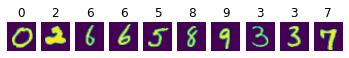

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt

choice = np.random.choice(X_test.shape[0],10)
random_image = X_test[choice]
random_label = y_test[choice]

fig,ax = plt.subplots(1,10)
for i in range(10):
    ax[i].set_title(random_label[i])
    ax[i].imshow(random_image[i])
    ax[i].axis('off')

We also can plot the average image for every digit, and get a general view over all training data.

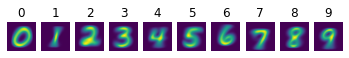

In [5]:
fig,ax = plt.subplots(1,10)
for i in range(10):
    ax[i].set_title(i)
    ax[i].imshow(np.average(X_train[np.where(y_train == i)],axis=0))
    ax[i].axis('off')

In [6]:
# first reshape train data to fit matrix calculus
X_train = np.reshape(X_train, (X_train.shape[0], -1)) / 256
X_test  = np.reshape(X_test,  (X_test.shape[0],  -1)) / 256
print(X_train.shape, X_test.shape)

(60000, 784) (10000, 784)


### SVM

https://scikit-learn.org/stable/modules/svm.html

linear

In [7]:
from sklearn import svm
from sklearn.metrics import accuracy_score,f1_score

model = svm.SVC(kernel='linear')
model.fit(X_train[:10000],y_train[:10000])

y_pred = model.predict(X_test)
print("The model accuracy is:",accuracy_score(y_test,y_pred),
      'f1_score is:',f1_score(y_test,y_pred,average='micro'))

The model accuracy is: 0.9172 f1_score is: 0.9171999999999999


non-linear

In [8]:
model = svm.SVC(kernel='rbf',gamma='scale')
model.fit(X_train[:10000],y_train[:10000])

y_pred = model.predict(X_test)
print("The model accuracy is:",accuracy_score(y_test,y_pred),
      'f1_score is:',f1_score(y_test,y_pred,average='micro'))

The model accuracy is: 0.9594 f1_score is: 0.9594


### MLPNN

https://github.com/PyTorchLightning/deep-learning-project-template/blob/master/project/lit_mnist.py

In [9]:
import torch
import pytorch_lightning as pl
from torch.nn import functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split

class LitClassifier(pl.LightningModule):
    def __init__(self, loss, hidden_dim=128, learning_rate=1e-3):
        super().__init__()
        self.save_hyperparameters()
        
        self.l1 = torch.nn.Linear(28 * 28, self.hparams.hidden_dim)
        self.l2 = torch.nn.Linear(self.hparams.hidden_dim, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = torch.relu(self.l1(x))
        x = torch.relu(self.l2(x))
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.hparams.loss(y_hat, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.hparams.loss(y_hat, y)
        y_hat = torch.argmax(y_hat, dim=1)
        acc = pl.metrics.functional.classification.accuracy(y_hat,y)
        self.log_dict({'val_loss': loss,'val_accuracy': acc})

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = self.hparams.loss(y_hat, y)
        y_hat = torch.argmax(y_hat, dim=1)
        f1 = pl.metrics.functional.classification.f1_score(y_hat,y)
        acc = pl.metrics.functional.classification.accuracy(y_hat,y)
        self.log_dict({'test_loss': loss,'f1_score':f1 ,'accuracy': acc})

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

Load data into Pytorch

In [12]:
batch_size = 32

X_train_tensor = torch.tensor(X_train,dtype=torch.float32)
y_train_tensor = torch.tensor(y_train)
X_test_tensor = torch.tensor(X_test,dtype=torch.float32)
y_test_tensor = torch.tensor(y_test)
    
dataset = TensorDataset(X_train_tensor,y_train_tensor)
mnist_test = TensorDataset(X_test_tensor,y_test_tensor)
mnist_train, mnist_val = random_split(dataset, [len(dataset)-len(dataset)//5,len(dataset)//5])

train_loader = DataLoader(mnist_train, batch_size=batch_size, num_workers=12)
val_loader = DataLoader(mnist_val, batch_size=batch_size ,num_workers=12)
test_loader = DataLoader(mnist_test, batch_size=batch_size, num_workers=12)

Train with CE Loss

https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss

In [13]:
trainer = pl.Trainer(gpus=1, max_epochs=10)
model = LitClassifier(loss=F.cross_entropy)
trainer.fit(model, train_loader, val_loader)
trainer.test(test_dataloaders=test_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 100 K 
1 | l2   | Linear | 1 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': tensor(0.8422, device='cuda:0'),
 'f1_score': tensor(0.8422, device='cuda:0'),
 'test_loss': tensor(0.7248, device='cuda:0'),
 'val_accuracy': tensor(0.8577, device='cuda:0'),
 'val_loss': tensor(0.6181, device='cuda:0')}
--------------------------------------------------------------------------------



[{'val_loss': 0.6180801391601562,
  'val_accuracy': 0.8576666712760925,
  'test_loss': 0.7247751951217651,
  'f1_score': 0.842199981212616,
  'accuracy': 0.842199981212616}]

Train with Hinge Loss

https://pytorch.org/docs/stable/generated/torch.nn.MultiMarginLoss.html#torch.nn.MultiMarginLoss

In [14]:
trainer = pl.Trainer(gpus=1, max_epochs=10)
model = LitClassifier(loss=F.multi_margin_loss)
trainer.fit(model, train_loader, val_loader)
trainer.test(test_dataloaders=test_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type   | Params
--------------------------------
0 | l1   | Linear | 100 K 
1 | l2   | Linear | 1 K   


--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'accuracy': tensor(0.6245, device='cuda:0'),
 'f1_score': tensor(0.6245, device='cuda:0'),
 'test_loss': tensor(0.3671, device='cuda:0'),
 'val_accuracy': tensor(0.6848, device='cuda:0'),
 'val_loss': tensor(0.2850, device='cuda:0')}
--------------------------------------------------------------------------------



[{'val_loss': 0.2849788963794708,
  'val_accuracy': 0.6847500205039978,
  'test_loss': 0.3671487867832184,
  'f1_score': 0.6244999766349792,
  'accuracy': 0.6244999766349792}]